In [1]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn
import cv2
from PIL import Image
import warnings


In [2]:
#hyper params
lr = 1e-3
wd = 1e-3
feature_extract = True
#lr = 1e-4
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 60
hardness_threshold = 0.60
lambda_u = 0.1  # Weighting factor for the unsupervised loss
patience = 4
classes = [10,11,14,16,6,7] #arranged in order of their placement in the folder
num_classes = len(classes)
path = './only_relevant_dataset'


In [3]:
def transform_denoise(image):
    # Denoising transformation (replace with your denoising algorithm)
    # Example: Apply Gaussian blur with a kernel size of 3
    denoised_image = transforms.functional.gaussian_blur(image, kernel_size=3,sigma=1.5)
    return denoised_image

def transform_enhance(image):
    # Image enhancement transformation (replace with your enhancement algorithm)
    # Example: Apply contrast enhancement
    enhanced_image = transforms.functional.adjust_contrast(image, contrast_factor=1.5)
    return enhanced_image

In [4]:

def get_dataset(path,val_split,test_split):
    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.Lambda(lambda x: transform_denoise(x)),
                                        transforms.Lambda(lambda x: transform_enhance(x)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset= datasets.ImageFolder(path,transform=transform_strong)

    trainset,valset,testset = stratified(dataset)
    
    print("train :",len(trainset),"val :",len(valset),"test :",len(testset))

    
    return trainset,valset,testset

In [5]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [6]:
def train_model(trainset,valset, model, criterion, optimizer, scheduler_train , scheduler_val, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset, batch_size=bs, shuffle=True)
    }

    dataset_sizes_strong = {'train': len(trainset), 'val': len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epochs_without_improvement = 0  # Reset the counter since there is improvement

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    E_accuracy_train = []
    E_accuracy_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy

            # Iterate over data.
            for inputs, labels in dataloaders_strong[phase]:
                inputs = inputs.to(device)                
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # AdaMatch steps
                    if phase == 'train':
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())


                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                        # Backpropagation and optimization
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    else:
                                                
                        # Calculate hardness score for each sample in the batch
                        probabilities_hard = torch.softmax(outputs, dim=1)
                        hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

                        # Skip predictions if hardness score is greater than the threshold
                        skip_mask = hardness_scores <= hardness_threshold
                    
                    
                        if skip_mask.sum().item() > 0:
                            c += 1
                            inputs = inputs[skip_mask]
                            labels = labels[skip_mask]
                            preds = preds[skip_mask]
                            loss = criterion(outputs[skip_mask], preds)
                                                    
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())
                            
                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            
            if phase == 'train':
                epoch_loss = running_loss / dataset_sizes_strong[phase]
                epoch_acc = running_corrects.double() / dataset_sizes_strong[phase]
                epoch_entropy /= dataset_sizes_strong[phase] # Calculate average epoch entropy
            else:
                epoch_loss = running_loss / (dataset_sizes_strong[phase]-c)
                epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]-c)
                epoch_entropy /= (dataset_sizes_strong[phase]-c) # Calculate average epoch entropy
            
            if phase == 'train':
                scheduler_train.step()
                print()

                
            if phase == 'val':
                scheduler_val.step(epoch_loss)
                print('Number of skipped:', c)
                print()
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                entropy_values_train.append(epoch_entropy.item())
                E_loss_train.append(epoch_loss)
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
                E_accuracy_train.append(epoch_acc)
            else:
                entropy_values_val.append(epoch_entropy.item())
                E_loss_val.append(epoch_loss)
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation
                E_accuracy_val.append(epoch_acc)


            
            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()
            
            # Deep copy the model if the validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch_val = epoch
                
                
            # Early stopping criteria
            if phase == 'val' and epoch > 0:
                if epoch_loss >= E_loss_val[-1]:
                    epochs_without_improvement += 1
                else:
                    epochs_without_improvement = 0

                if epochs_without_improvement >= patience:
                    print('Early stopping due to no improvement in validation loss.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    ) 
                
            # Overfitting criteria
            if phase == 'train' and epoch_loss <= E_loss_train[-1]:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print('Training stopped due to overfitting.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    )
            else:
                epochs_without_improvement = 0
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best Val Acc. was achieved at epoch', best_epoch_val)
    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val,
        E_accuracy_train,
        E_accuracy_val
    )
  

In [7]:
def test_model(model, testset, hardness_threshold):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

         # Calculate hardness score for each sample in the batch
            probabilities_hard = torch.softmax(outputs, dim=1)
            hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

            # Skip predictions if hardness score is greater than the threshold
            skip_mask = hardness_scores <= hardness_threshold
                    
                    
            if skip_mask.sum().item() > 0:
                c += 1
                inputs = inputs[skip_mask]
                labels = labels[skip_mask]
                preds = preds[skip_mask]
                
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / (len(testset)-c)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)
    print("Skipped Inputs:", c)
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [8]:

def weighted_score_array(models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [9]:
def set_parameter_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [11]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        # Resnet50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
        

    elif model_name == "vgg":
        # VGG16_bn
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "googlenet":
        # GoogLeNet
        model_ft = torchvision.models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(1024, num_classes)

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier = nn.Linear(1024, num_classes)

    elif model_name == "vit":
        # Vision Transformer (ViT)
        model_ft = models.vit_b_16(weights = models.ViT_B_16_Weights.DEFAULT)
        set_parameter_requires_grad(model_ft, requires_grad=use_pretrained)
        #num_features = model_ft.fc.in_features
        #model_ft.fc = nn.Sequential(
                   # nn.Linear(num_features, 512),
                    #nn.ReLU(),
                    #nn.Linear(512, num_classes)
                    #)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [12]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [13]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [14]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()
# Separate the train, val, and test sets
trainset,valset,testset = get_dataset(path, val_size, test_size)

train : 9628 val : 2408 test : 2124


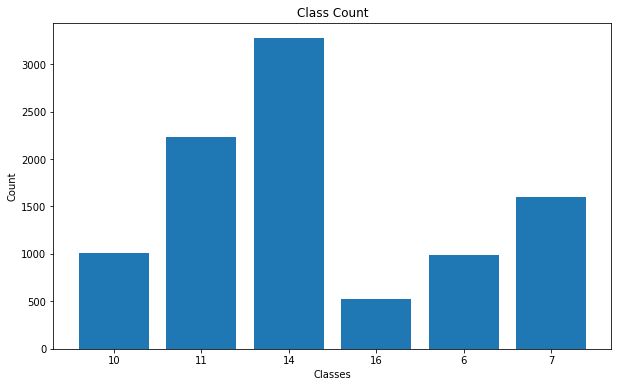

In [15]:
plot_distribution_by_class(trainset, classes)

resnet


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

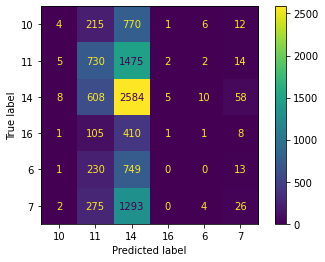

<Figure size 576x432 with 0 Axes>

Number of skipped: 292

val Loss: 0.4293 Acc: 0.1824
val Epoch Entropy: 2.6220
val Balanced Accuracy: 0.0000



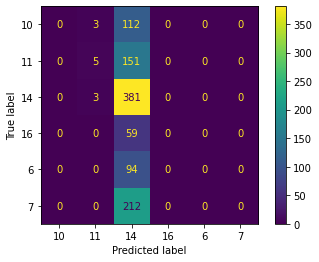

<Figure size 576x432 with 0 Axes>

Epoch 1/59
----------

train Loss: 1.5561 Acc: 0.3936
train Epoch Entropy: 2.2110
train Balanced Accuracy: 0.3333



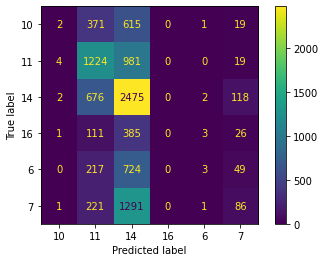

<Figure size 576x432 with 0 Axes>

Number of skipped: 300

val Loss: 0.3186 Acc: 0.2533
val Epoch Entropy: 2.2213
val Balanced Accuracy: 0.2500



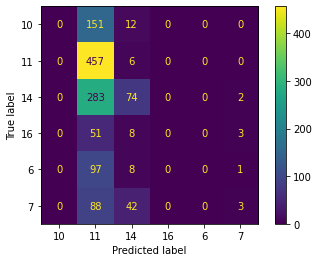

<Figure size 576x432 with 0 Axes>

Epoch 2/59
----------

train Loss: 1.4515 Acc: 0.4493
train Epoch Entropy: 2.0665
train Balanced Accuracy: 0.0000



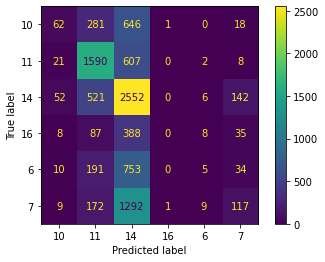

<Figure size 576x432 with 0 Axes>

Number of skipped: 297

val Loss: 0.3352 Acc: 0.2691
val Epoch Entropy: 2.3675
val Balanced Accuracy: 0.2500



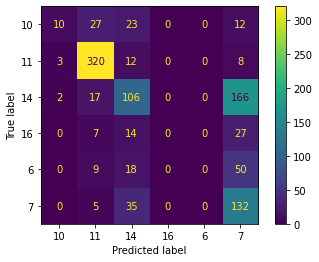

<Figure size 576x432 with 0 Axes>

Epoch 3/59
----------

train Loss: 1.3797 Acc: 0.4767
train Epoch Entropy: 1.9725
train Balanced Accuracy: 0.5000



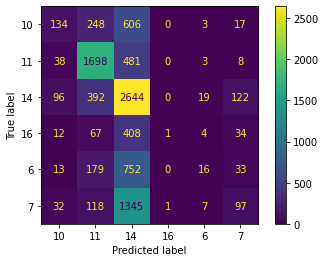

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.3337 Acc: 0.2962
val Epoch Entropy: 2.0948
val Balanced Accuracy: 0.5556



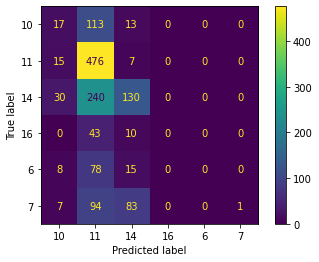

<Figure size 576x432 with 0 Axes>

Epoch 4/59
----------

train Loss: 1.3473 Acc: 0.4842
train Epoch Entropy: 1.9261
train Balanced Accuracy: 0.1667



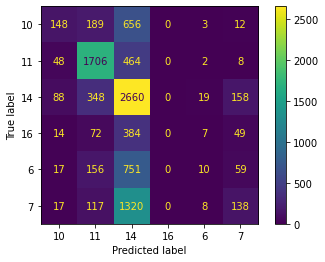

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.5142 Acc: 0.4428
val Epoch Entropy: 2.1063
val Balanced Accuracy: 0.5000



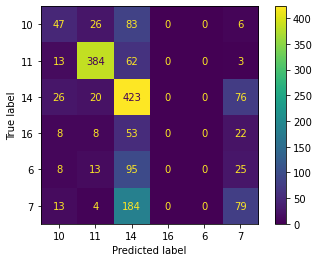

<Figure size 576x432 with 0 Axes>

Epoch 5/59
----------

train Loss: 1.3235 Acc: 0.4913
train Epoch Entropy: 1.8898
train Balanced Accuracy: 0.2500



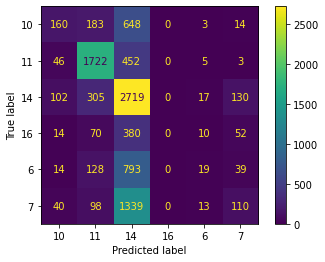

<Figure size 576x432 with 0 Axes>

Number of skipped: 299

val Loss: 0.3333 Acc: 0.3367
val Epoch Entropy: 2.1937
val Balanced Accuracy: 0.5000



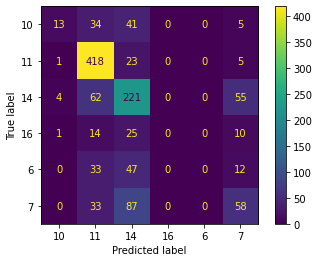

<Figure size 576x432 with 0 Axes>

Epoch 6/59
----------

train Loss: 1.3195 Acc: 0.4891
train Epoch Entropy: 1.8895
train Balanced Accuracy: 0.1667



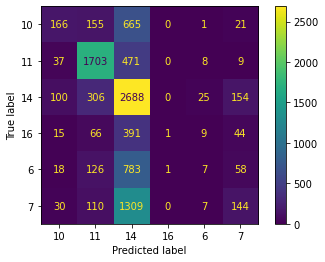

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4350 Acc: 0.4366
val Epoch Entropy: 2.1182
val Balanced Accuracy: 0.1667



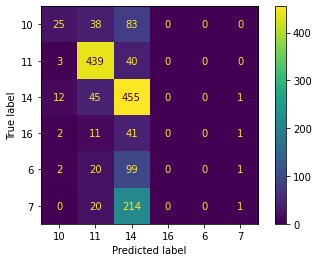

<Figure size 576x432 with 0 Axes>

Epoch 7/59
----------

train Loss: 1.2815 Acc: 0.5004
train Epoch Entropy: 1.8377
train Balanced Accuracy: 0.6667



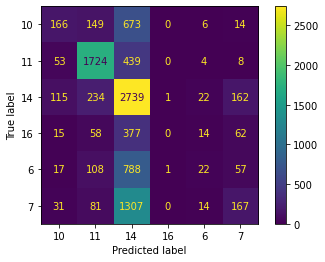

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4138 Acc: 0.4328
val Epoch Entropy: 1.9936
val Balanced Accuracy: 0.5000



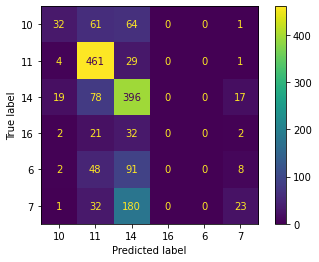

<Figure size 576x432 with 0 Axes>

Epoch 8/59
----------

train Loss: 1.2361 Acc: 0.5138
train Epoch Entropy: 1.7991
train Balanced Accuracy: 0.5000



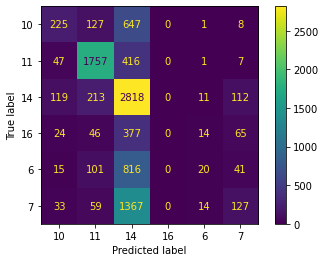

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4818 Acc: 0.4760
val Epoch Entropy: 2.0493
val Balanced Accuracy: 0.7778



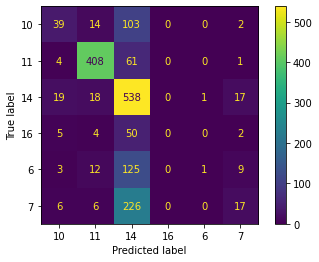

<Figure size 576x432 with 0 Axes>

Epoch 9/59
----------

train Loss: 1.2193 Acc: 0.5248
train Epoch Entropy: 1.7789
train Balanced Accuracy: 0.5000



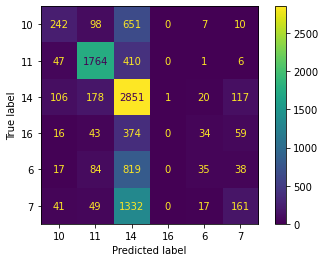

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4470 Acc: 0.4651
val Epoch Entropy: 2.0234
val Balanced Accuracy: 0.5000



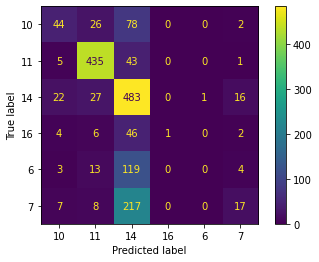

<Figure size 576x432 with 0 Axes>

Epoch 10/59
----------

train Loss: 1.2174 Acc: 0.5264
train Epoch Entropy: 1.7726
train Balanced Accuracy: 0.1667



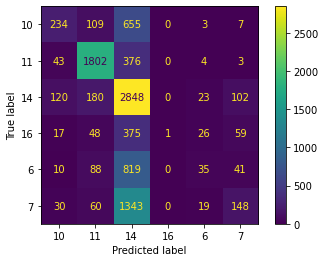

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4633 Acc: 0.4665
val Epoch Entropy: 2.0057
val Balanced Accuracy: 0.5000



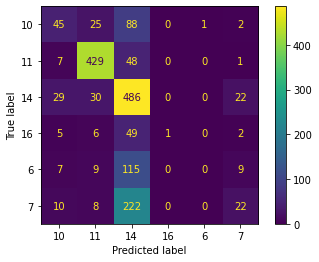

<Figure size 576x432 with 0 Axes>

Epoch 11/59
----------

train Loss: 1.2160 Acc: 0.5235
train Epoch Entropy: 1.7732
train Balanced Accuracy: 0.6667



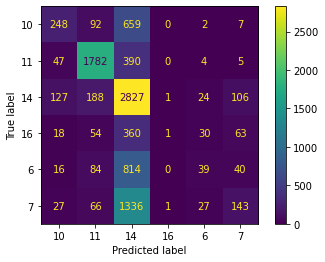

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4575 Acc: 0.4623
val Epoch Entropy: 2.0141
val Balanced Accuracy: 0.8333



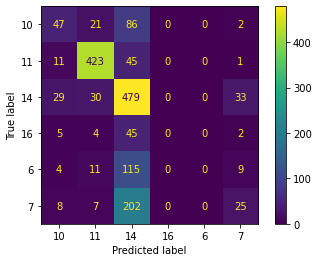

<Figure size 576x432 with 0 Axes>

Epoch 12/59
----------

train Loss: 1.2119 Acc: 0.5257
train Epoch Entropy: 1.7721
train Balanced Accuracy: 0.5000



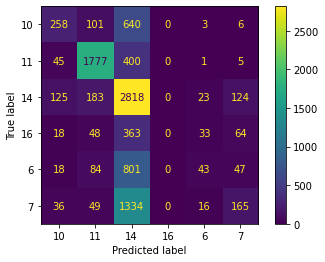

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4522 Acc: 0.4632
val Epoch Entropy: 2.0205
val Balanced Accuracy: 0.5000



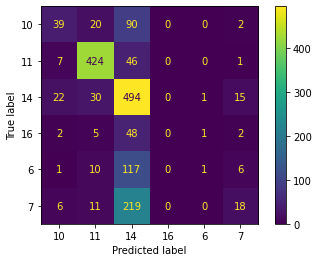

<Figure size 576x432 with 0 Axes>

Epoch 13/59
----------

train Loss: 1.2149 Acc: 0.5300
train Epoch Entropy: 1.7654
train Balanced Accuracy: 0.3333



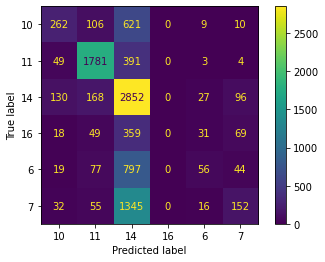

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4725 Acc: 0.4737
val Epoch Entropy: 2.0119
val Balanced Accuracy: 0.2917



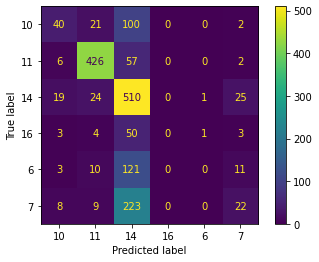

<Figure size 576x432 with 0 Axes>

Epoch 14/59
----------

train Loss: 1.2143 Acc: 0.5253
train Epoch Entropy: 1.7641
train Balanced Accuracy: 0.2500



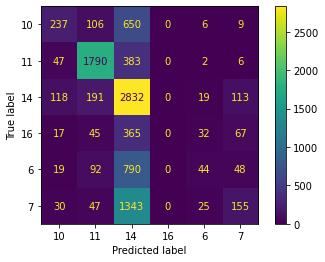

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4565 Acc: 0.4680
val Epoch Entropy: 2.0180
val Balanced Accuracy: 0.5000



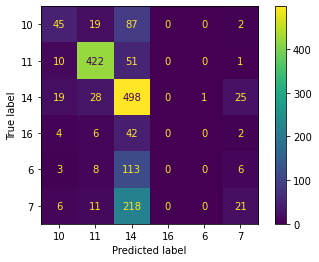

<Figure size 576x432 with 0 Axes>

Epoch 15/59
----------

train Loss: 1.2084 Acc: 0.5281
train Epoch Entropy: 1.7662
train Balanced Accuracy: 0.7500



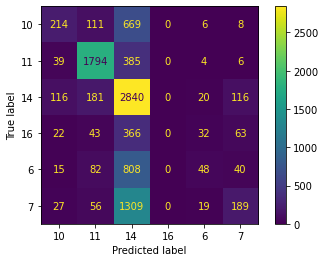

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4702 Acc: 0.4680
val Epoch Entropy: 2.0193
val Balanced Accuracy: 0.5833



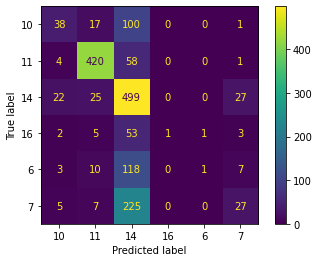

<Figure size 576x432 with 0 Axes>

Epoch 16/59
----------

train Loss: 1.2058 Acc: 0.5290
train Epoch Entropy: 1.7695
train Balanced Accuracy: 0.7500



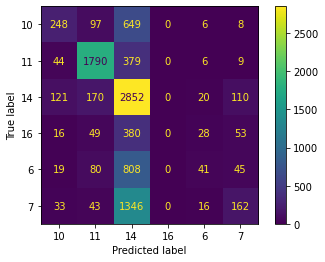

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4487 Acc: 0.4642
val Epoch Entropy: 2.0243
val Balanced Accuracy: 0.5000



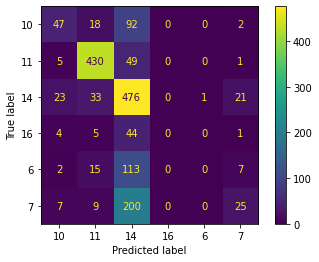

<Figure size 576x432 with 0 Axes>

Epoch 17/59
----------

train Loss: 1.2084 Acc: 0.5276
train Epoch Entropy: 1.7665
train Balanced Accuracy: 0.5000



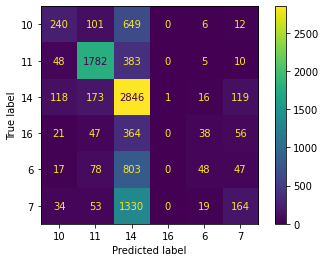

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4708 Acc: 0.4703
val Epoch Entropy: 2.0128
val Balanced Accuracy: 0.3333



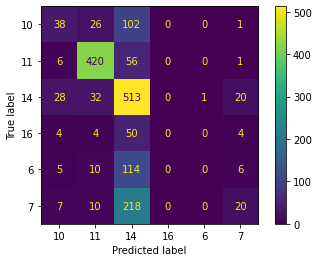

<Figure size 576x432 with 0 Axes>

Epoch 18/59
----------

train Loss: 1.2099 Acc: 0.5254
train Epoch Entropy: 1.7657
train Balanced Accuracy: 0.6667



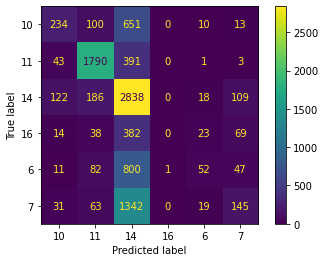

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4988 Acc: 0.4898
val Epoch Entropy: 1.9947
val Balanced Accuracy: 0.0000



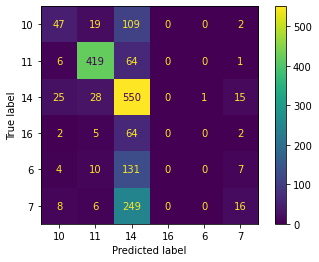

<Figure size 576x432 with 0 Axes>

Epoch 19/59
----------

train Loss: 1.2097 Acc: 0.5287
train Epoch Entropy: 1.7649
train Balanced Accuracy: 0.5000



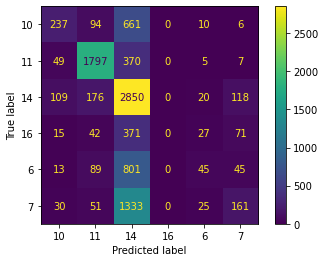

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4646 Acc: 0.4703
val Epoch Entropy: 2.0031
val Balanced Accuracy: 0.2500



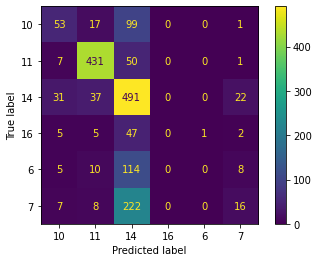

<Figure size 576x432 with 0 Axes>

Epoch 20/59
----------

train Loss: 1.2062 Acc: 0.5281
train Epoch Entropy: 1.7665
train Balanced Accuracy: 0.2500



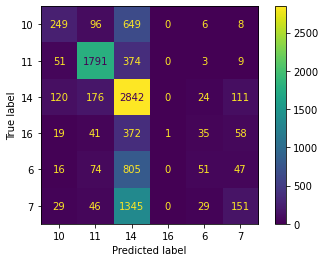

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4748 Acc: 0.4703
val Epoch Entropy: 2.0086
val Balanced Accuracy: 0.5000



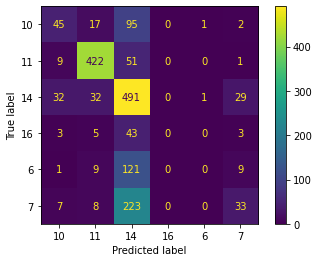

<Figure size 576x432 with 0 Axes>

Epoch 21/59
----------

train Loss: 1.2101 Acc: 0.5267
train Epoch Entropy: 1.7636
train Balanced Accuracy: 1.0000



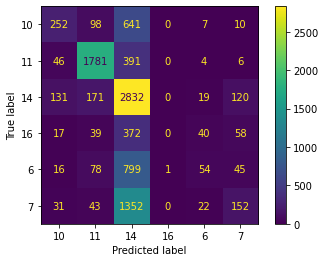

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4481 Acc: 0.4632
val Epoch Entropy: 2.0119
val Balanced Accuracy: 0.5000



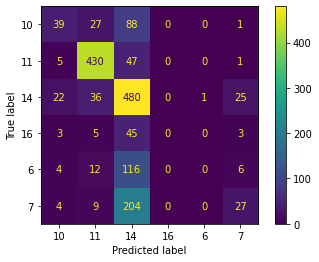

<Figure size 576x432 with 0 Axes>

Epoch 22/59
----------

train Loss: 1.2090 Acc: 0.5221
train Epoch Entropy: 1.7661
train Balanced Accuracy: 0.3333



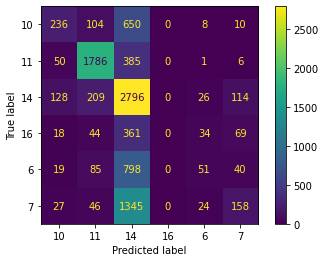

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4889 Acc: 0.4869
val Epoch Entropy: 1.9900
val Balanced Accuracy: 0.3333



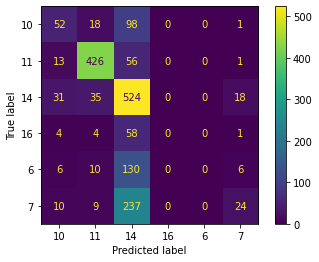

<Figure size 576x432 with 0 Axes>

Epoch 23/59
----------

train Loss: 1.2110 Acc: 0.5231
train Epoch Entropy: 1.7617
train Balanced Accuracy: 0.6667



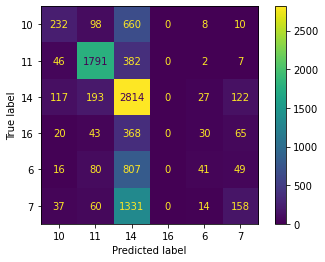

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4734 Acc: 0.4703
val Epoch Entropy: 2.0230
val Balanced Accuracy: 0.5000



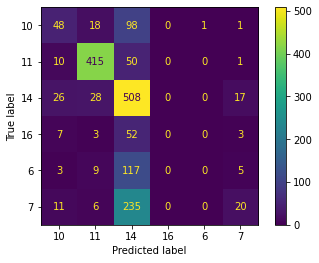

<Figure size 576x432 with 0 Axes>

Epoch 24/59
----------

train Loss: 1.2108 Acc: 0.5251
train Epoch Entropy: 1.7697
train Balanced Accuracy: 0.1667



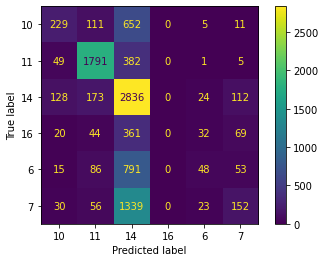

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4632 Acc: 0.4680
val Epoch Entropy: 2.0053
val Balanced Accuracy: 0.6000



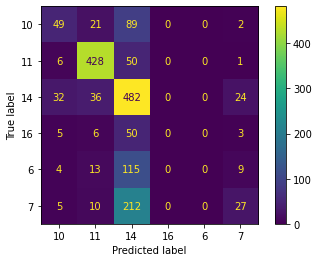

<Figure size 576x432 with 0 Axes>

Epoch 25/59
----------

train Loss: 1.2098 Acc: 0.5260
train Epoch Entropy: 1.7668
train Balanced Accuracy: 0.6667



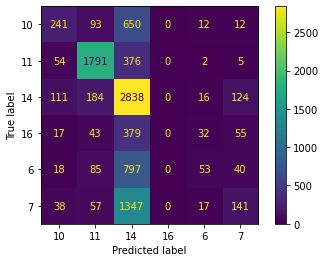

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4999 Acc: 0.4893
val Epoch Entropy: 1.9987
val Balanced Accuracy: 0.7500



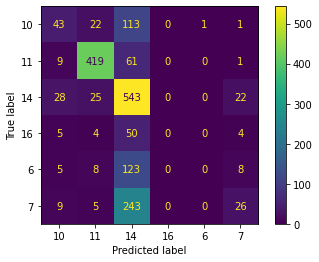

<Figure size 576x432 with 0 Axes>

Epoch 26/59
----------

train Loss: 1.2110 Acc: 0.5298
train Epoch Entropy: 1.7646
train Balanced Accuracy: 0.5000



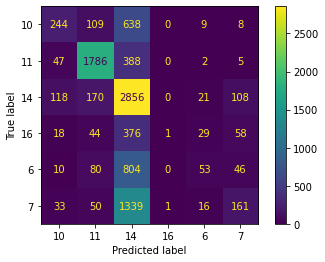

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.5090 Acc: 0.4841
val Epoch Entropy: 2.0038
val Balanced Accuracy: 0.5556



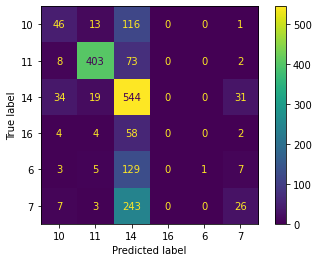

<Figure size 576x432 with 0 Axes>

Epoch 27/59
----------

train Loss: 1.2116 Acc: 0.5265
train Epoch Entropy: 1.7672
train Balanced Accuracy: 0.3333



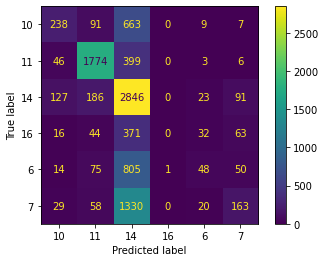

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4591 Acc: 0.4613
val Epoch Entropy: 2.0153
val Balanced Accuracy: 0.5000



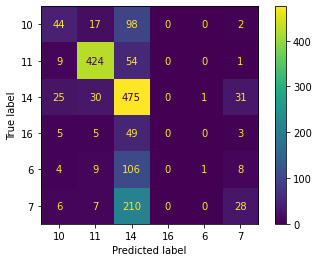

<Figure size 576x432 with 0 Axes>

Epoch 28/59
----------

train Loss: 1.2138 Acc: 0.5283
train Epoch Entropy: 1.7658
train Balanced Accuracy: 0.2500



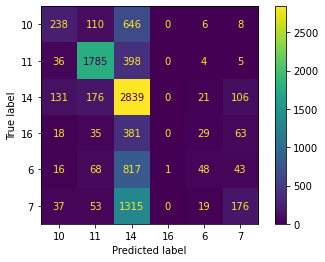

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4571 Acc: 0.4613
val Epoch Entropy: 2.0106
val Balanced Accuracy: 0.5833



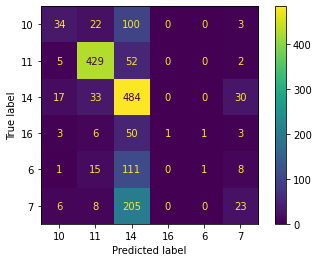

<Figure size 576x432 with 0 Axes>

Epoch 29/59
----------

train Loss: 1.2081 Acc: 0.5271
train Epoch Entropy: 1.7659
train Balanced Accuracy: 0.3333



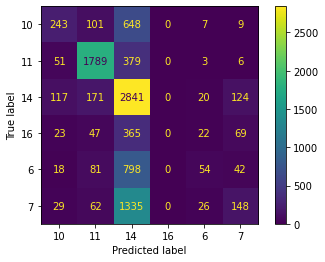

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4824 Acc: 0.4770
val Epoch Entropy: 1.9955
val Balanced Accuracy: 1.0000



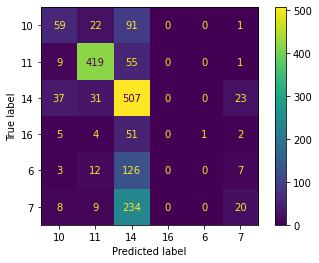

<Figure size 576x432 with 0 Axes>

Epoch 30/59
----------

train Loss: 1.2058 Acc: 0.5291
train Epoch Entropy: 1.7618
train Balanced Accuracy: 1.0000



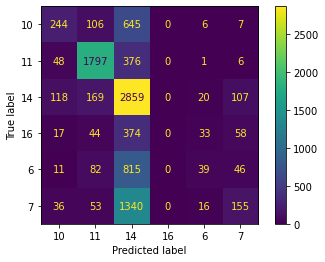

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.5014 Acc: 0.4912
val Epoch Entropy: 1.9944
val Balanced Accuracy: 0.3750



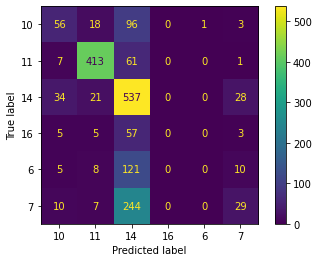

<Figure size 576x432 with 0 Axes>

Epoch 31/59
----------

train Loss: 1.2135 Acc: 0.5259
train Epoch Entropy: 1.7694
train Balanced Accuracy: 0.2500



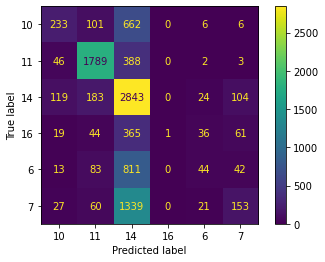

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4722 Acc: 0.4770
val Epoch Entropy: 1.9967
val Balanced Accuracy: 0.4167



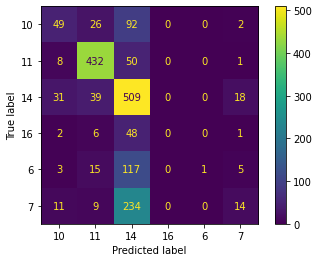

<Figure size 576x432 with 0 Axes>

Epoch 32/59
----------

train Loss: 1.2105 Acc: 0.5233
train Epoch Entropy: 1.7677
train Balanced Accuracy: 0.6667



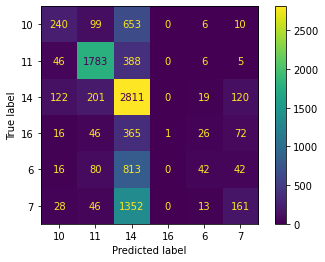

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4595 Acc: 0.4675
val Epoch Entropy: 2.0056
val Balanced Accuracy: 0.6667



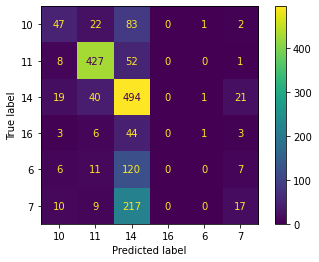

<Figure size 576x432 with 0 Axes>

Epoch 33/59
----------

train Loss: 1.2106 Acc: 0.5290
train Epoch Entropy: 1.7671
train Balanced Accuracy: 0.2500



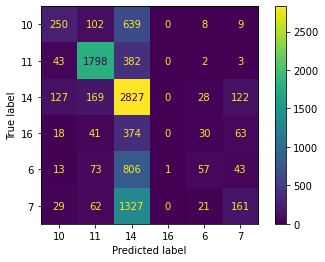

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4678 Acc: 0.4703
val Epoch Entropy: 2.0234
val Balanced Accuracy: 0.5000



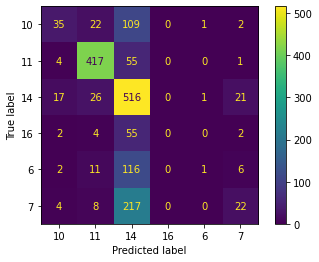

<Figure size 576x432 with 0 Axes>

Epoch 34/59
----------

train Loss: 1.2110 Acc: 0.5283
train Epoch Entropy: 1.7670
train Balanced Accuracy: 0.6667



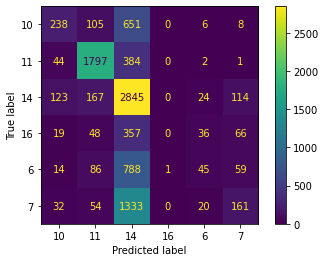

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4914 Acc: 0.4903
val Epoch Entropy: 2.0009
val Balanced Accuracy: 0.2500



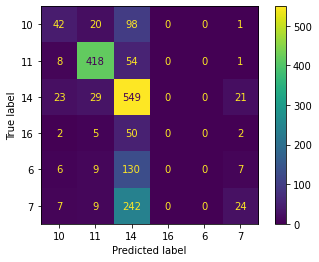

<Figure size 576x432 with 0 Axes>

Epoch 35/59
----------

train Loss: 1.2064 Acc: 0.5253
train Epoch Entropy: 1.7653
train Balanced Accuracy: 0.3333



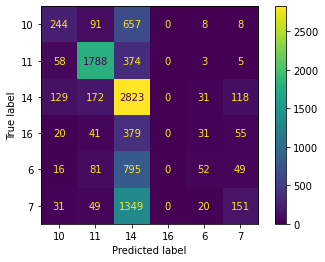

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4702 Acc: 0.4713
val Epoch Entropy: 2.0117
val Balanced Accuracy: 0.6667



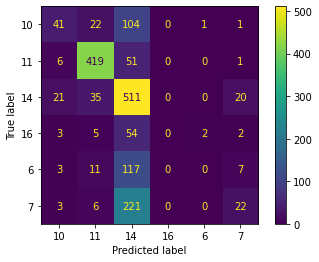

<Figure size 576x432 with 0 Axes>

Epoch 36/59
----------

train Loss: 1.2112 Acc: 0.5260
train Epoch Entropy: 1.7687
train Balanced Accuracy: 0.3333



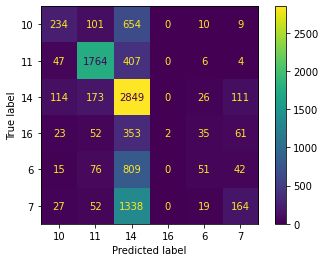

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4724 Acc: 0.4756
val Epoch Entropy: 1.9995
val Balanced Accuracy: 0.2500



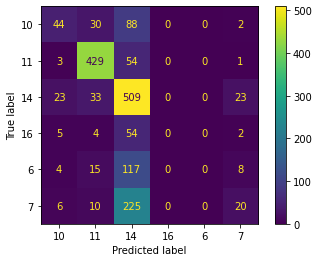

<Figure size 576x432 with 0 Axes>

Epoch 37/59
----------

train Loss: 1.2063 Acc: 0.5272
train Epoch Entropy: 1.7650
train Balanced Accuracy: 0.6667



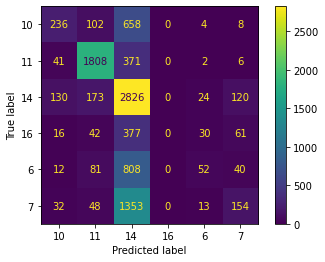

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4710 Acc: 0.4775
val Epoch Entropy: 2.0171
val Balanced Accuracy: 0.3333



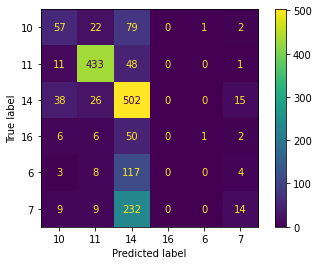

<Figure size 576x432 with 0 Axes>

Epoch 38/59
----------

train Loss: 1.2116 Acc: 0.5257
train Epoch Entropy: 1.7673
train Balanced Accuracy: 0.1667



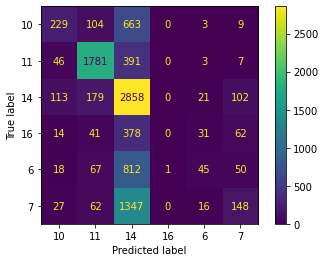

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4620 Acc: 0.4618
val Epoch Entropy: 2.0178
val Balanced Accuracy: 0.4000



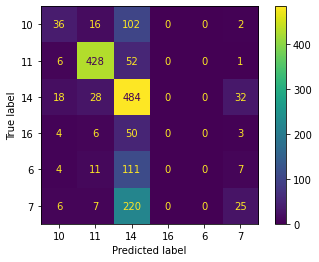

<Figure size 576x432 with 0 Axes>

Epoch 39/59
----------

train Loss: 1.2140 Acc: 0.5239
train Epoch Entropy: 1.7653
train Balanced Accuracy: 0.6667



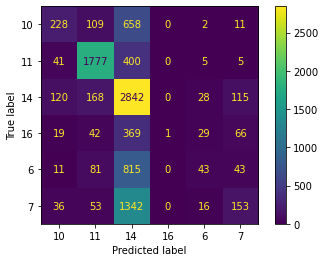

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4921 Acc: 0.4869
val Epoch Entropy: 1.9908
val Balanced Accuracy: 0.6000



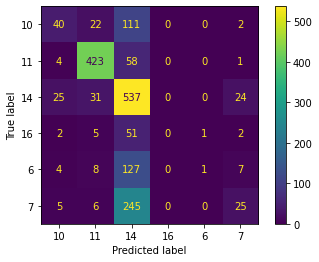

<Figure size 576x432 with 0 Axes>

Epoch 40/59
----------

train Loss: 1.2074 Acc: 0.5271
train Epoch Entropy: 1.7685
train Balanced Accuracy: 0.3333



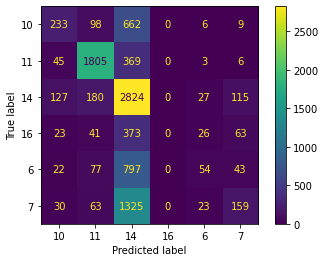

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4843 Acc: 0.4846
val Epoch Entropy: 2.0012
val Balanced Accuracy: 0.2500



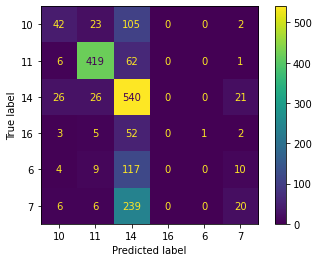

<Figure size 576x432 with 0 Axes>

Epoch 41/59
----------

train Loss: 1.2126 Acc: 0.5283
train Epoch Entropy: 1.7690
train Balanced Accuracy: 0.3333



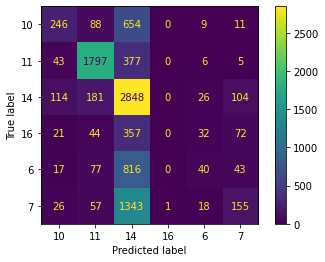

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4651 Acc: 0.4713
val Epoch Entropy: 2.0012
val Balanced Accuracy: 1.0000



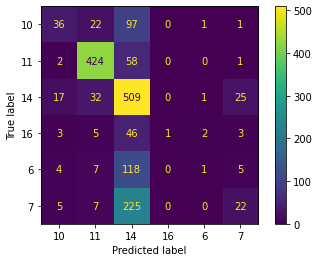

<Figure size 576x432 with 0 Axes>

Epoch 42/59
----------

train Loss: 1.2150 Acc: 0.5266
train Epoch Entropy: 1.7643
train Balanced Accuracy: 0.0000



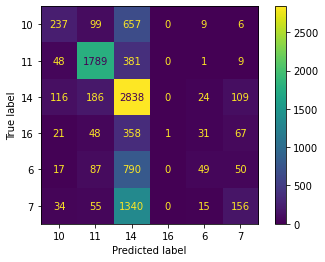

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4613 Acc: 0.4694
val Epoch Entropy: 1.9866
val Balanced Accuracy: 0.3333



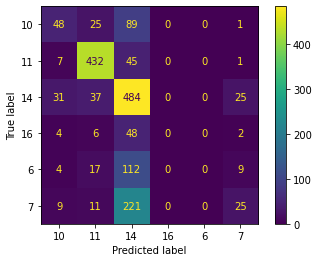

<Figure size 576x432 with 0 Axes>

Epoch 43/59
----------

train Loss: 1.2146 Acc: 0.5251
train Epoch Entropy: 1.7671
train Balanced Accuracy: 0.3333



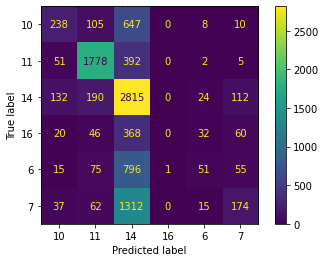

<Figure size 576x432 with 0 Axes>

Number of skipped: 300

val Loss: 0.4696 Acc: 0.4711
val Epoch Entropy: 2.0092
val Balanced Accuracy: 0.8333



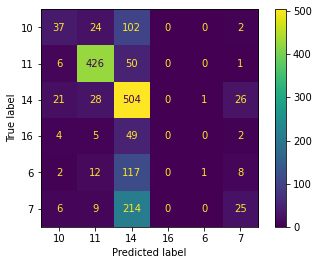

<Figure size 576x432 with 0 Axes>

Epoch 44/59
----------

train Loss: 1.2100 Acc: 0.5284
train Epoch Entropy: 1.7637
train Balanced Accuracy: 0.6667



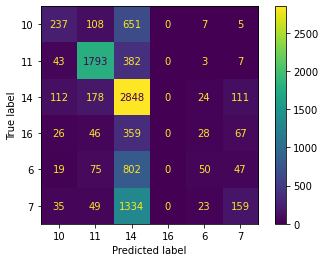

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4928 Acc: 0.4903
val Epoch Entropy: 1.9843
val Balanced Accuracy: 0.5000



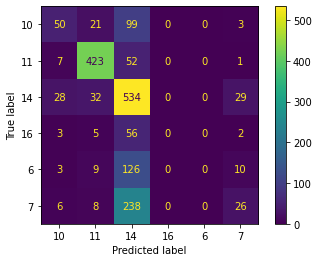

<Figure size 576x432 with 0 Axes>

Epoch 45/59
----------

train Loss: 1.2080 Acc: 0.5254
train Epoch Entropy: 1.7676
train Balanced Accuracy: 0.6667



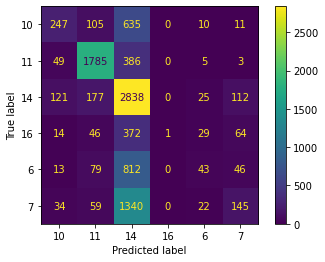

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4771 Acc: 0.4869
val Epoch Entropy: 2.0059
val Balanced Accuracy: 0.8333



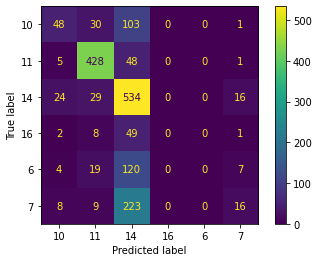

<Figure size 576x432 with 0 Axes>

Epoch 46/59
----------

train Loss: 1.2079 Acc: 0.5292
train Epoch Entropy: 1.7679
train Balanced Accuracy: 0.6667



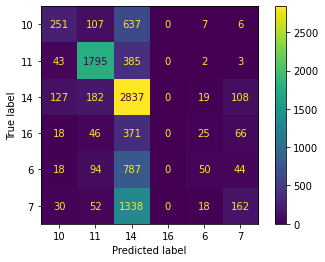

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4629 Acc: 0.4741
val Epoch Entropy: 2.0049
val Balanced Accuracy: 0.3333



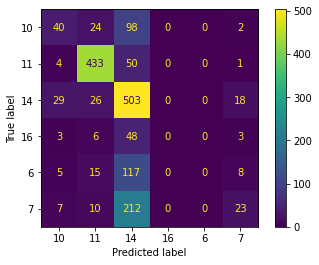

<Figure size 576x432 with 0 Axes>

Epoch 47/59
----------

train Loss: 1.2097 Acc: 0.5270
train Epoch Entropy: 1.7666
train Balanced Accuracy: 0.5000



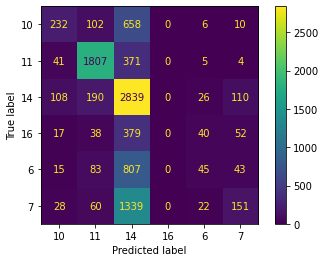

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4654 Acc: 0.4665
val Epoch Entropy: 2.0065
val Balanced Accuracy: 0.0000



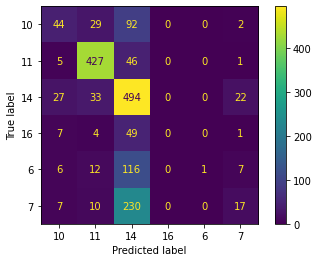

<Figure size 576x432 with 0 Axes>

Epoch 48/59
----------

train Loss: 1.2121 Acc: 0.5263
train Epoch Entropy: 1.7670
train Balanced Accuracy: 0.6667



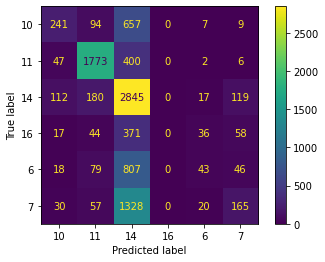

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4749 Acc: 0.4779
val Epoch Entropy: 2.0074
val Balanced Accuracy: 0.4000



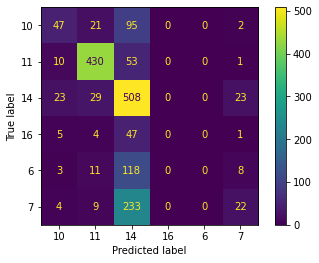

<Figure size 576x432 with 0 Axes>

Epoch 49/59
----------

train Loss: 1.2095 Acc: 0.5267
train Epoch Entropy: 1.7653
train Balanced Accuracy: 0.6667



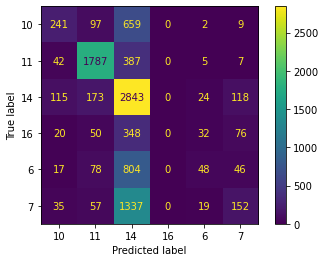

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4715 Acc: 0.4779
val Epoch Entropy: 1.9979
val Balanced Accuracy: 0.5000



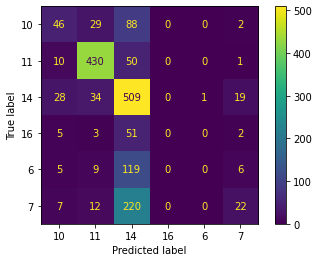

<Figure size 576x432 with 0 Axes>

Epoch 50/59
----------

train Loss: 1.2115 Acc: 0.5287
train Epoch Entropy: 1.7665
train Balanced Accuracy: 0.5000



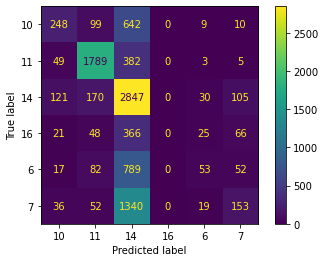

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4910 Acc: 0.4860
val Epoch Entropy: 2.0019
val Balanced Accuracy: 0.2083



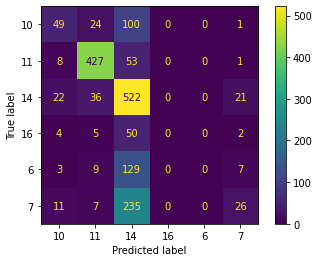

<Figure size 576x432 with 0 Axes>

Epoch 51/59
----------

train Loss: 1.2144 Acc: 0.5253
train Epoch Entropy: 1.7666
train Balanced Accuracy: 0.5000



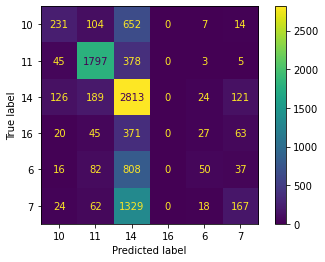

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4807 Acc: 0.4770
val Epoch Entropy: 1.9993
val Balanced Accuracy: 0.4167



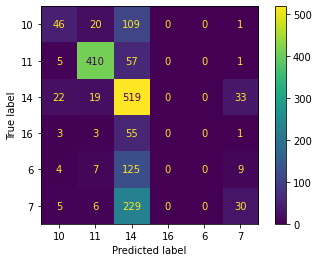

<Figure size 576x432 with 0 Axes>

Epoch 52/59
----------

train Loss: 1.2135 Acc: 0.5233
train Epoch Entropy: 1.7653
train Balanced Accuracy: 0.6667



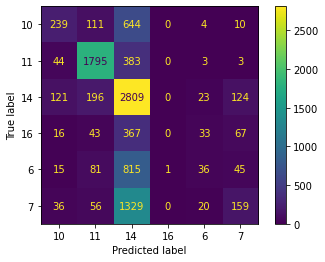

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4625 Acc: 0.4746
val Epoch Entropy: 2.0012
val Balanced Accuracy: 0.3750



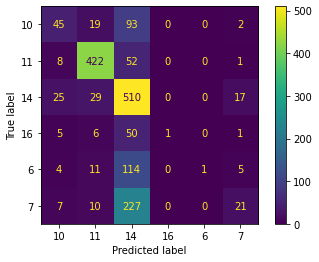

<Figure size 576x432 with 0 Axes>

Epoch 53/59
----------

train Loss: 1.2112 Acc: 0.5279
train Epoch Entropy: 1.7665
train Balanced Accuracy: 0.3333



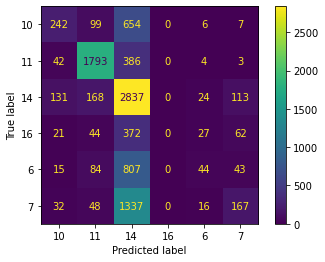

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4642 Acc: 0.4680
val Epoch Entropy: 2.0170
val Balanced Accuracy: 0.6667



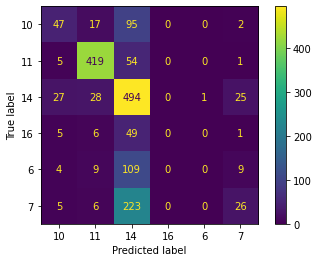

<Figure size 576x432 with 0 Axes>

Epoch 54/59
----------

train Loss: 1.2112 Acc: 0.5273
train Epoch Entropy: 1.7683
train Balanced Accuracy: 0.3333



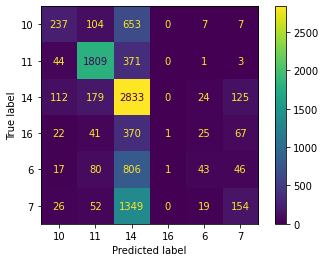

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4545 Acc: 0.4661
val Epoch Entropy: 2.0113
val Balanced Accuracy: 0.5000



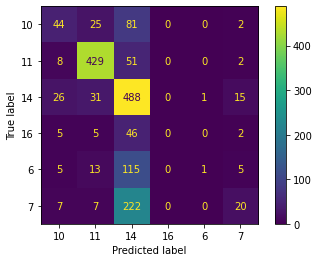

<Figure size 576x432 with 0 Axes>

Epoch 55/59
----------

train Loss: 1.2151 Acc: 0.5288
train Epoch Entropy: 1.7658
train Balanced Accuracy: 0.2500



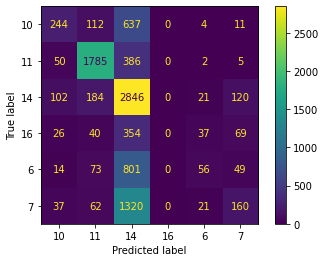

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4973 Acc: 0.4803
val Epoch Entropy: 1.9882
val Balanced Accuracy: 0.3750



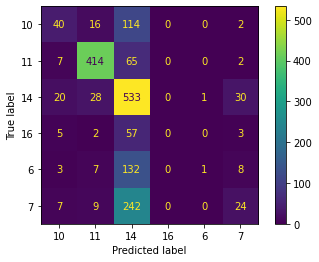

<Figure size 576x432 with 0 Axes>

Epoch 56/59
----------

train Loss: 1.2119 Acc: 0.5280
train Epoch Entropy: 1.7660
train Balanced Accuracy: 0.5000



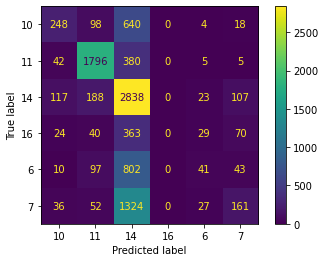

<Figure size 576x432 with 0 Axes>

Number of skipped: 300

val Loss: 0.4627 Acc: 0.4673
val Epoch Entropy: 2.0090
val Balanced Accuracy: 0.5000



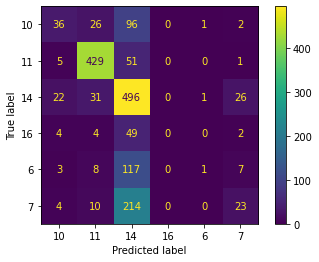

<Figure size 576x432 with 0 Axes>

Epoch 57/59
----------

train Loss: 1.2154 Acc: 0.5285
train Epoch Entropy: 1.7668
train Balanced Accuracy: 0.7500



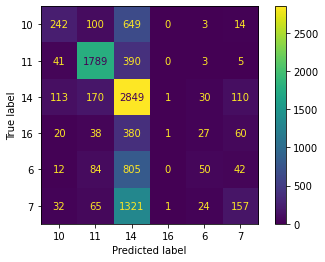

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4755 Acc: 0.4708
val Epoch Entropy: 2.0106
val Balanced Accuracy: 0.5000



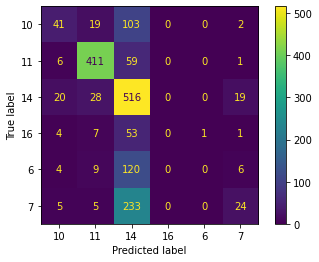

<Figure size 576x432 with 0 Axes>

Epoch 58/59
----------

train Loss: 1.2141 Acc: 0.5239
train Epoch Entropy: 1.7657
train Balanced Accuracy: 0.5000



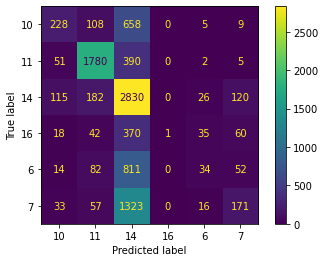

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4777 Acc: 0.4770
val Epoch Entropy: 1.9898
val Balanced Accuracy: 0.4167



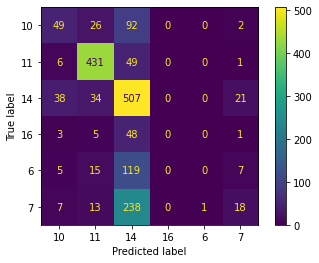

<Figure size 576x432 with 0 Axes>

Epoch 59/59
----------

train Loss: 1.2142 Acc: 0.5235
train Epoch Entropy: 1.7688
train Balanced Accuracy: 0.5000



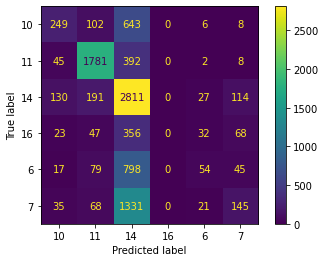

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4649 Acc: 0.4713
val Epoch Entropy: 1.9875
val Balanced Accuracy: 0.6667



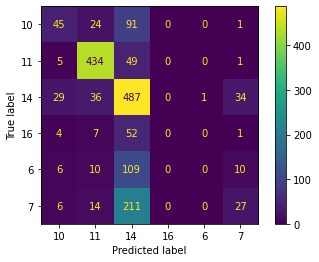

<Figure size 576x432 with 0 Axes>

Training complete in 140m 32s
Best val Acc: 0.491220
Best Val Acc. was achieved at epoch 30
vgg


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.3.weight
	 features.3.bias
	 features.4.weight
	 features.4.bias
	 features.7.weight
	 features.7.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 features.11.weight
	 features.11.bias
	 features.14.weight
	 features.14.bias
	 features.15.weight
	 features.15.bias
	 features.17.weight
	 features.17.bias
	 features.18.weight
	 features.18.bias
	 features.20.weight
	 features.20.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.25.weight
	 features.25.bias
	 features.27.weight
	 features.27.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.31.weight
	 features.31.bias
	 features.34.weight
	 features.34.bias
	 features.35.weight
	 features.35.bias
	 features.37.weight
	 features.37.bias
	 features.38.weight
	 features.38.bias
	 features.40.weight
	 features.40.

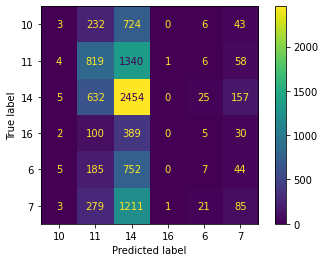

<Figure size 576x432 with 0 Axes>

Number of skipped: 287

val Loss: 0.3357 Acc: 0.2174
val Epoch Entropy: 2.4317
val Balanced Accuracy: 0.3333



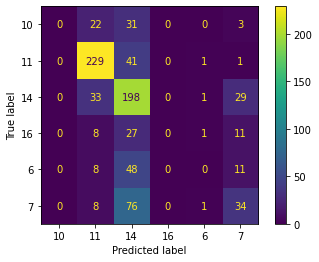

<Figure size 576x432 with 0 Axes>

Epoch 1/59
----------

train Loss: 1.4814 Acc: 0.4448
train Epoch Entropy: 2.0333
train Balanced Accuracy: 0.2500



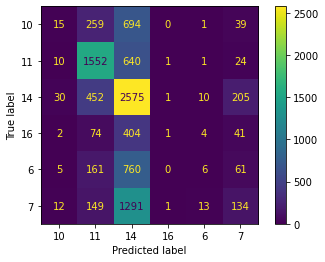

<Figure size 576x432 with 0 Axes>

Number of skipped: 299

val Loss: 0.3456 Acc: 0.3001
val Epoch Entropy: 2.3759
val Balanced Accuracy: 0.6667



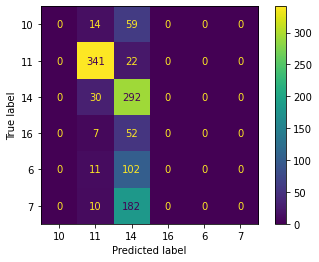

<Figure size 576x432 with 0 Axes>

Epoch 2/59
----------

train Loss: 1.4396 Acc: 0.4558
train Epoch Entropy: 1.9217
train Balanced Accuracy: 0.2500



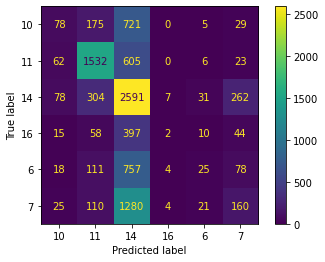

<Figure size 576x432 with 0 Axes>

Number of skipped: 278

val Loss: 0.2883 Acc: 0.2643
val Epoch Entropy: 2.3700
val Balanced Accuracy: 0.3333



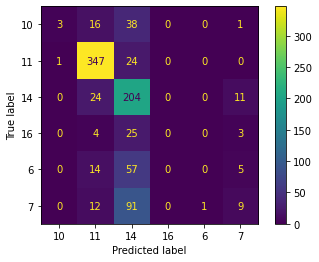

<Figure size 576x432 with 0 Axes>

Epoch 3/59
----------

train Loss: 1.3648 Acc: 0.4795
train Epoch Entropy: 1.8898
train Balanced Accuracy: 0.5000



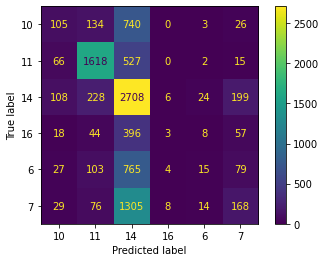

<Figure size 576x432 with 0 Axes>

Number of skipped: 292

val Loss: 0.2288 Acc: 0.2732
val Epoch Entropy: 2.2026
val Balanced Accuracy: 0.5000



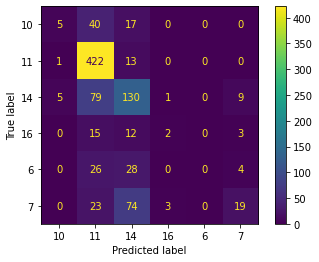

<Figure size 576x432 with 0 Axes>

Epoch 4/59
----------

train Loss: 1.3269 Acc: 0.4877
train Epoch Entropy: 1.8553
train Balanced Accuracy: 0.6667



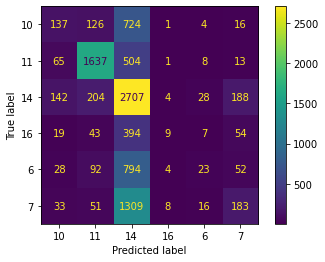

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.5554 Acc: 0.5059
val Epoch Entropy: 2.0720
val Balanced Accuracy: 0.3750



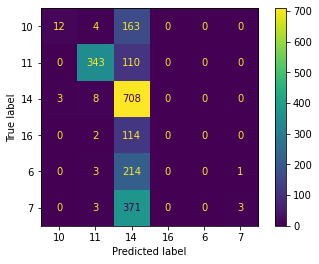

<Figure size 576x432 with 0 Axes>

Epoch 5/59
----------

train Loss: 1.3208 Acc: 0.4868
train Epoch Entropy: 1.8435
train Balanced Accuracy: 0.5000



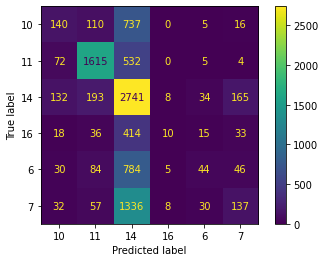

<Figure size 576x432 with 0 Axes>

Number of skipped: 301

val Loss: 0.4159 Acc: 0.4352
val Epoch Entropy: 2.1442
val Balanced Accuracy: 0.5000



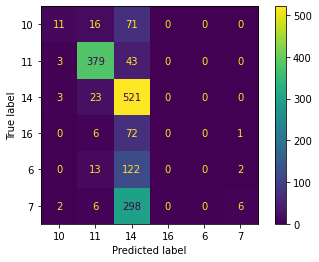

<Figure size 576x432 with 0 Axes>

Epoch 6/59
----------

train Loss: 1.3201 Acc: 0.4907
train Epoch Entropy: 1.8276
train Balanced Accuracy: 0.0000



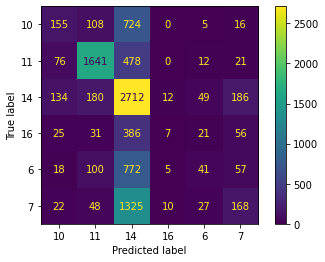

<Figure size 576x432 with 0 Axes>

Number of skipped: 300

val Loss: 0.3612 Acc: 0.3790
val Epoch Entropy: 2.0990
val Balanced Accuracy: 0.3333



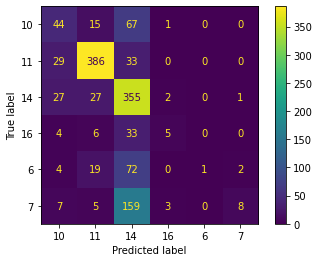

<Figure size 576x432 with 0 Axes>

Epoch 7/59
----------

train Loss: 1.3220 Acc: 0.4873
train Epoch Entropy: 1.8143
train Balanced Accuracy: 0.7500



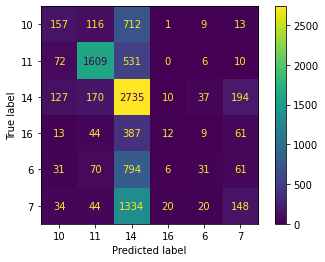

<Figure size 576x432 with 0 Axes>

Number of skipped: 295

val Loss: 0.3018 Acc: 0.3299
val Epoch Entropy: 2.1772
val Balanced Accuracy: 0.0000



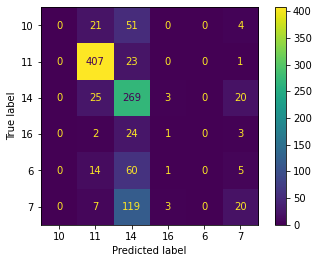

<Figure size 576x432 with 0 Axes>

Epoch 8/59
----------

train Loss: 1.2890 Acc: 0.4988
train Epoch Entropy: 1.7989
train Balanced Accuracy: 0.3333



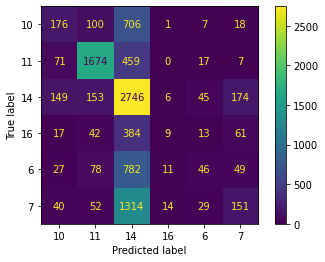

<Figure size 576x432 with 0 Axes>

Number of skipped: 298

val Loss: 0.3389 Acc: 0.3706
val Epoch Entropy: 2.1169
val Balanced Accuracy: 1.0000



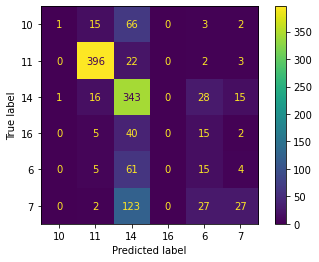

<Figure size 576x432 with 0 Axes>

Epoch 9/59
----------


KeyboardInterrupt: 

In [16]:
model_list = []

for model_name in ["resnet","vgg","googlenet","densenet"]:
    
    print(model_name)
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr)

    exp_lr_scheduler_train = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)
    exp_lr_scheduler_val = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-9)


    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val,E_accuracy_train,E_accuracy_val = train_model(trainset,valset,model, criterion, optimizer, exp_lr_scheduler_train,exp_lr_scheduler_val, num_epoch, bs,hardness_threshold)
    
    model_list.append(model)



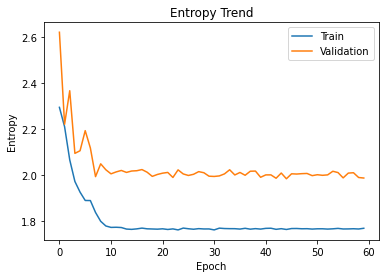

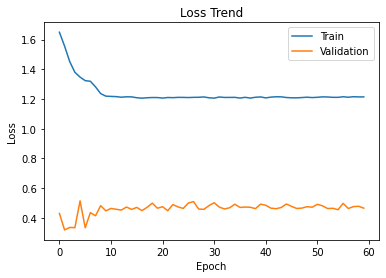

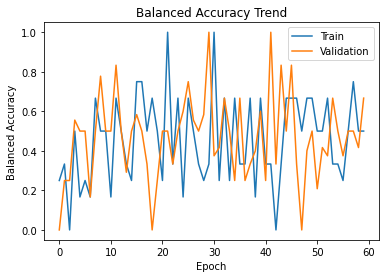

In [17]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Trend')
plt.legend()
plt.show()




In [43]:

# Assuming you have a trained model named "model"


# Define the file path to save the model
model_file1 = './model_state.pt'

# Save the model
torch.save(model.state_dict(), model_file1)

model_file2 = './model_entire.pt'

# Save the entire model
torch.save(model, model_file2)


In [40]:

# Create an instance of the ResNet50 model
model = torch.load('./model_entire.pt')

# Load the state dictionary from the model_state file
state_dict = torch.load('./model_state.pt')

# Load the state dictionary into the model
model.load_state_dict(state_dict)



<All keys matched successfully>

The Test Accuracy: tensor(0.5942, device='cuda:0')
The Test Balanced Accuracy: 0.34579868085636534
Skipped Inputs: 266


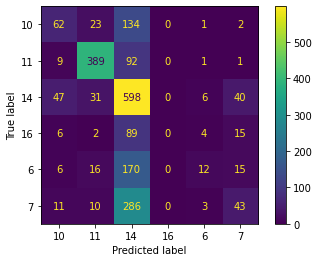

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.5958, device='cuda:0')
The Test Balanced Accuracy: 0.3447778462750391
Skipped Inputs: 266


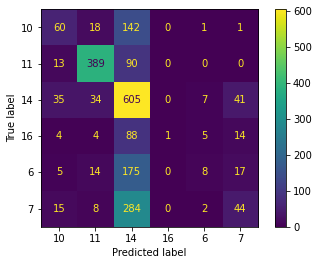

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.5861, device='cuda:0')
The Test Balanced Accuracy: 0.33951287003737846
Skipped Inputs: 266


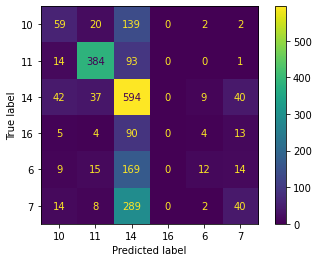

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.5904, device='cuda:0')
The Test Balanced Accuracy: 0.3435774213906509
Skipped Inputs: 266


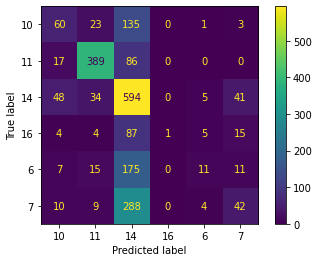

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.5942, device='cuda:0')
The Test Balanced Accuracy: 0.34130234222501876
Skipped Inputs: 266


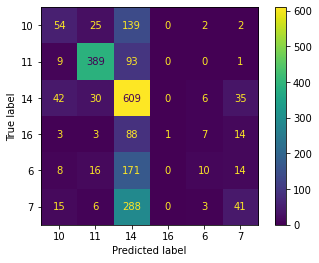

<Figure size 576x432 with 0 Axes>

In [18]:
for model in model_list:
    for hardness_threshold in [30,35,40,60,75]:
        test_model(model, testset, hardness_threshold)


In [19]:
train_X, train_Y = weighted_score_array(model_list, trainset)
test_X, test_Y = weighted_score_array(model_list, testset)

In [20]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.17749529190207156


Accuracy for SVM: 0.5207156308851224
Balanced Accuracy:0.34635845141644545


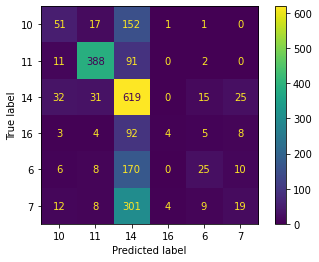

<Figure size 576x432 with 0 Axes>

In [21]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.4915254237288136
Balanced Accuracy:0.35387235908907555


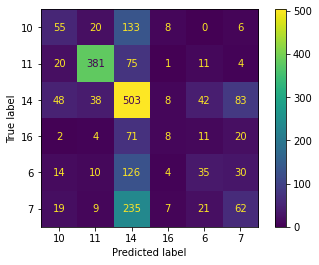

<Figure size 576x432 with 0 Axes>

In [22]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()